<a href="https://colab.research.google.com/github/HodaMemar/Patient-Similarity-through-Representation/blob/main/CreateTree_Relabeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import networkx as nx
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import textwrap



The following function is used to draw a hierarchical tree structure

In [2]:
def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

Stage refers to the set of quadraples that are used to make the graph.
This collection is arranged according to the time dimension

We designed two types of stages to design two methods U-TTree and H_U_TTree. which is in H_U_TTree data extracted from past medical history.

In [3]:
data=[[1	,'Retro',	'DiseaseDisorderMention',	'Diabet Mellitus'],
[1,	'New Finding',	'Demographic',	'Femail_40'],
[2,	'New Finding',	'DiseaseDisorderMention',	'Diabet_Neu'],
[3,	'RealTime',	'MainDrug',	'Insulin'],
[3,	'RealTime',	'Glucose',	'High']
      ]



Stage_df2 = pd.DataFrame(data, columns=['Time',	'TemporalEventType',	'Event'	,'Value'])
Stage_df2

,Time,TemporalEventType,Event,Value
0,1,Retro,DiseaseDisorderMention,Diabet Mellitus
1,1,New Finding,Demographic,Femail_40
2,2,New Finding,DiseaseDisorderMention,Diabet_Neu
3,3,RealTime,MainDrug,Insulin
4,3,RealTime,Glucose,High


In [4]:
Times=Stage_df2.Time.unique()
TemporalEventTypes=Stage_df2.TemporalEventType.unique()
Retro=Stage_df2.loc[Stage_df2['TemporalEventType']=='Retro','Event'].unique()

**Create Tree**

<Figure size 640x480 with 0 Axes>

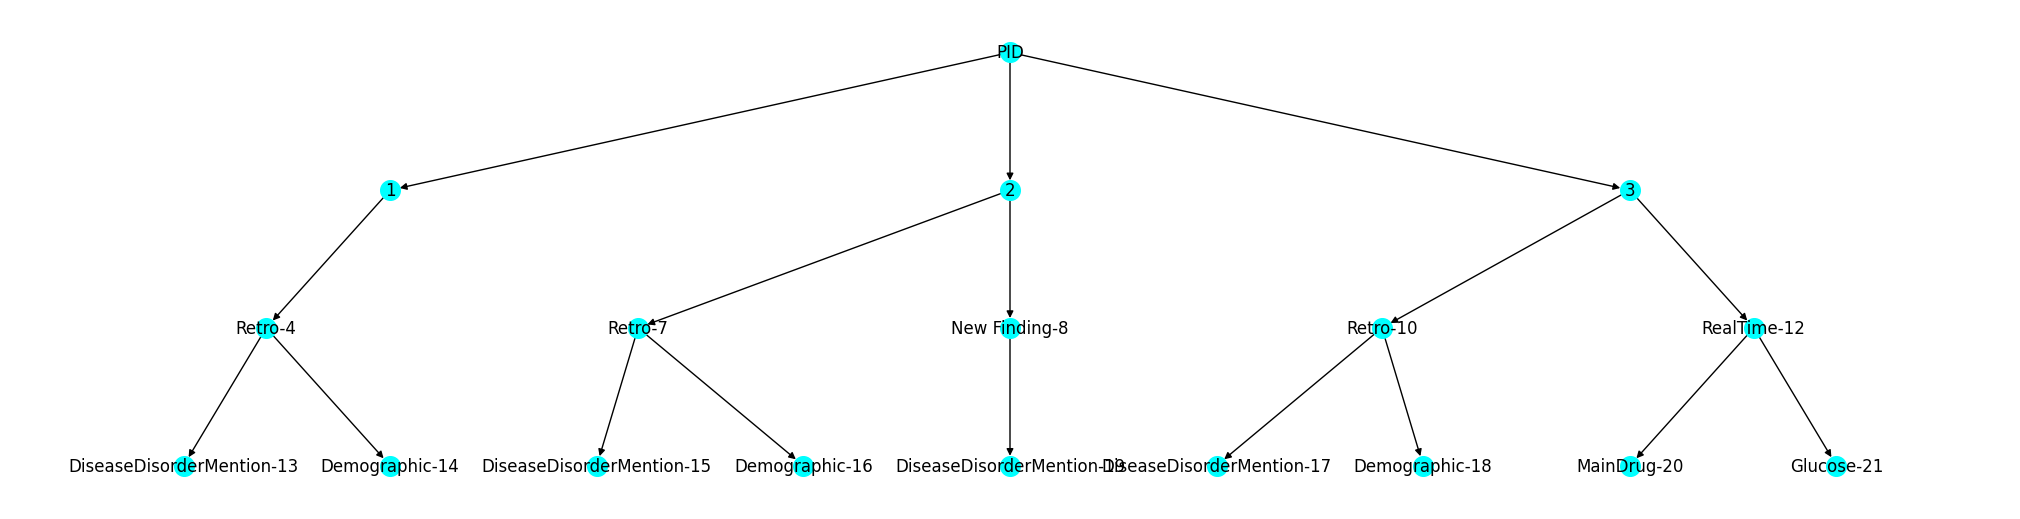

In [5]:
PG = nx.DiGraph()
PG.add_node('PID')
root='PID'
for i in Times:
  PG.add_node(i)
  PG.add_edge(root,i)


L_1=list(PG.successors(root))

for i in L_1:

  PG.add_node('Retro' + '-' +str(PG.number_of_nodes()), TE='Retro')
  PG.add_edge(i,'Retro'  + '-' +str(PG.number_of_nodes()-1))
  PG.add_node('New Finding'  + '-' +str(PG.number_of_nodes()), TE='New_Finding')
  PG.add_edge(i,'New Finding'  + '-' +str(PG.number_of_nodes()-1))
  PG.add_node('RealTime'  + '-' +str(PG.number_of_nodes()), TE='RealTime')
  PG.add_edge(i,'RealTime'  + '-' +str(PG.number_of_nodes()-1))


#-------------------------------------------------------------------------------------------------------
#In UTTree-H we use Retro data in creating Tree.
#-------------------------------------------------------------------------------------------------------
L2_Retro=[x for x,y in PG.nodes(data=True) if list(y.keys())==['TE'] and list(y.values())==['Retro']]

#or i in range(len(L2_Retro)):
#        PG.add_node('PastEvent_' + L2_Retro[i] )
#        PG.add_edge(L2_Retro[i] ,'PastEvent_' + L2_Retro[i] )

#L3_Retro=list(filter(lambda x:'PastEvent_' in str(x),PG.nodes))

for i in range(len(L2_Retro)):
        PG.add_node('DiseaseDisorderMention' + '-' +str(PG.number_of_nodes()) ,value='Diabet Mellitus')
        PG.add_edge(L2_Retro[i] ,'DiseaseDisorderMention' + '-' +str(PG.number_of_nodes()-1) )


        PG.add_node('Demographic' + '-' +str(PG.number_of_nodes()) ,value='Femail_40')
        PG.add_edge(L2_Retro[i] ,'Demographic' + '-' +str(PG.number_of_nodes()-1) )
#-------------------------------------------------------------------------------------------------------
L2_New_Finding=[x for x,y in PG.nodes(data=True) if list(y.keys())==['TE'] and list(y.values())==['New_Finding']]

for i in range(len(L2_New_Finding)):
  predecessor=list(PG.predecessors(L2_New_Finding[i]))
  Tmp_df_New_Finding=Stage_df2.loc[(Stage_df2['TemporalEventType']=='New Finding') &
                       (Stage_df2['Event']!='Demographic') & (Stage_df2['Time']==predecessor[0]), ['Event', 'Value']]
  Ls_Event_New_Finding=Tmp_df_New_Finding.reset_index()[['Event', 'Value']].values.tolist()
  if len(Ls_Event_New_Finding)>0:
    for j in range(len(Ls_Event_New_Finding)):
      PG.add_node(Ls_Event_New_Finding[j][0]+ '-' +str(PG.number_of_nodes()),value=Ls_Event_New_Finding[j][1])
      PG.add_edge(L2_New_Finding[i],Ls_Event_New_Finding[j][0]+ '-' +str(PG.number_of_nodes()-1))

#---------------------------------------------------------------------------------------------------------

L2_RealTime=[x for x,y in PG.nodes(data=True) if list(y.keys())==['TE'] and list(y.values())==['RealTime']]

for i in range(len(L2_RealTime)):
  predecessor=list(PG.predecessors(L2_RealTime[i]))
  Tmp_df_RealTime=Stage_df2.loc[(Stage_df2['TemporalEventType']=='RealTime') &
                                   (Stage_df2['Time']==predecessor[0]), ['Event', 'Value']]
  Ls_Event_RealTime=Tmp_df_RealTime.reset_index()[['Event', 'Value']].values.tolist()
  if len(Ls_Event_RealTime)>0:
    for j in range(len(Ls_Event_RealTime)):
      PG.add_node(Ls_Event_RealTime[j][0]+ '-' +str(PG.number_of_nodes()),value=Ls_Event_RealTime[j][1])
      PG.add_edge(L2_RealTime[i],Ls_Event_RealTime[j][0]+ '-' +str(PG.number_of_nodes()-1))

#---------------------------------------------------------------------------------------------------------
remove_nodes=[]
for node in PG.nodes:
   if (nx.shortest_path_length(PG, source='PID', target=node)==2 and PG.out_degree(node)==0):
     remove_nodes.append(node)
for i in remove_nodes:
  PG.remove_node(i)
#---------------------------------------------------------------------------------------------------------
pos = hierarchy_pos(PG,'PID')

plt.figure(1)
plt.figure(2,figsize=(20,5))
nx.draw(PG, pos=pos,with_labels=True,node_size = 200,node_color = 'cyan')
plt.show()

**Relabeling Lavel 3**

<Figure size 640x480 with 0 Axes>

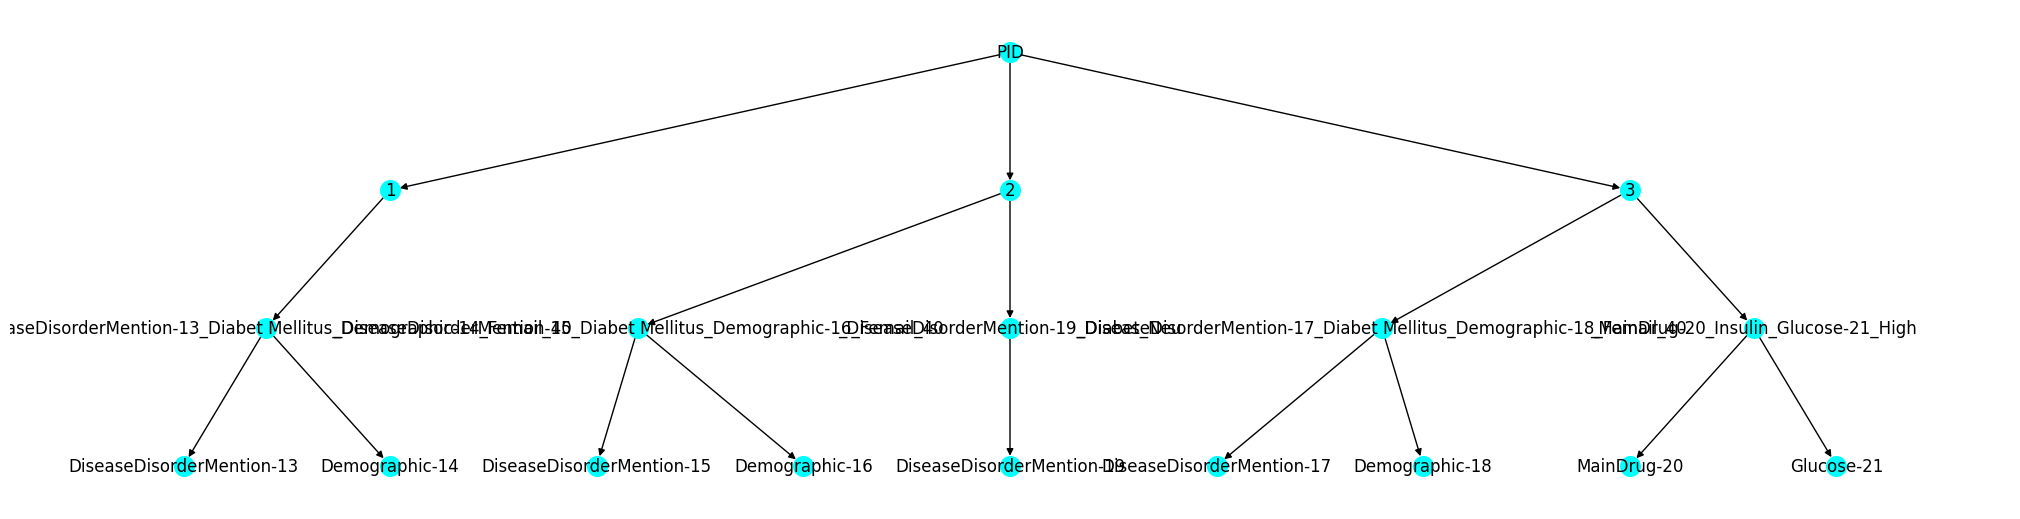

In [6]:
L3_nodes=[]
for node in PG.nodes:
  if (nx.shortest_path_length(PG, source='PID', target=node)==2):
    L3_nodes.append(node)

for i in L3_nodes:
  ls_tmp=[]
  new_label_1=''
  D=dict(nx.bfs_predecessors(PG, i))
  Ls_tmp=[k for k,v in D.items() ]
  for j in Ls_tmp:
    new_label_1=new_label_1+ '_'+j+ '_'+ PG.nodes[j]['value']

  mapping = {i:new_label_1 }
  PG = nx.relabel_nodes(PG, mapping)


pos = hierarchy_pos(PG,'PID')
plt.figure(1)
plt.figure(2,figsize=(20,5))
nx.draw(PG, pos=pos,with_labels=True,node_size = 200,node_color = 'cyan')
plt.show()

#--------------------------------------------------------------------------------



**Relabeling Lavel 2**

<Figure size 640x480 with 0 Axes>

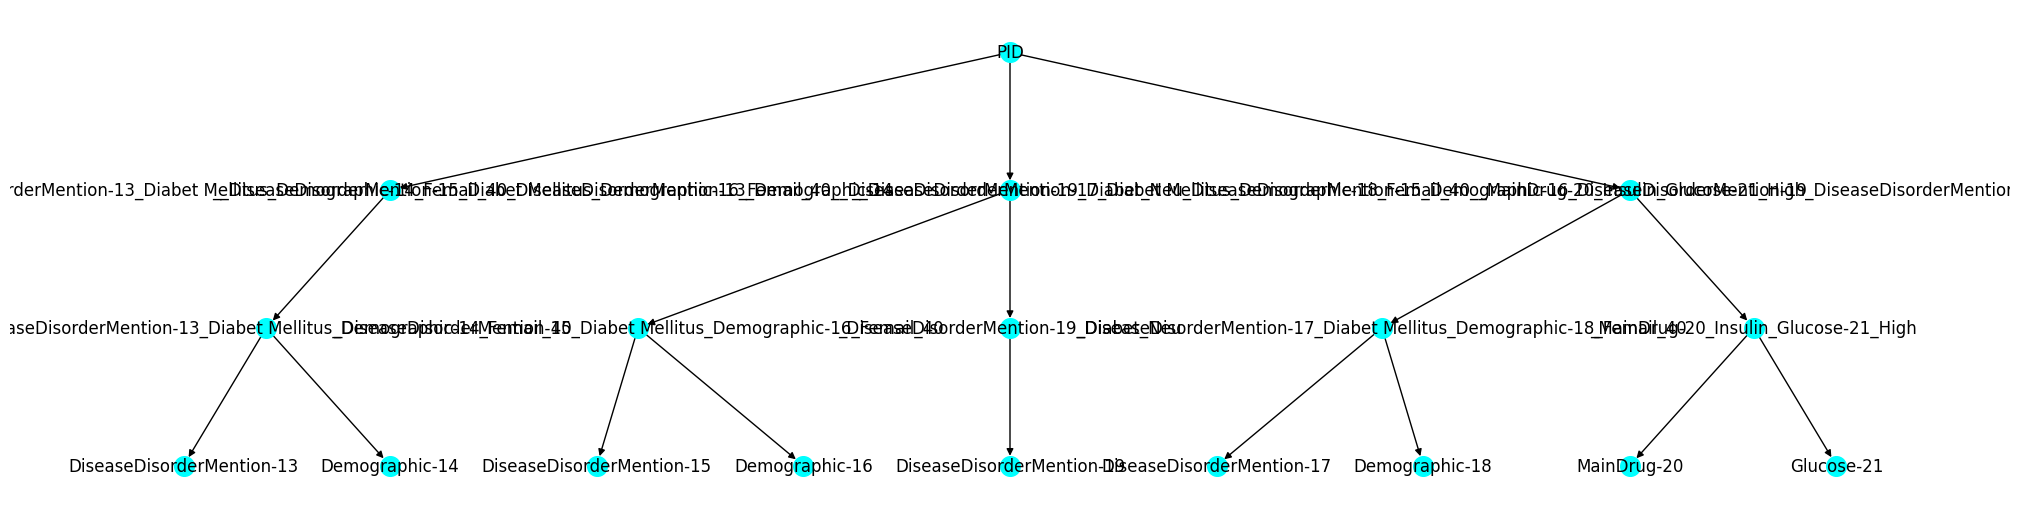

In [7]:
L2_nodes=[]
for node in PG.nodes:
  if (nx.shortest_path_length(PG, source='PID', target=node)==1):
    L2_nodes.append(node)

for i in L2_nodes:
  ls_tmp=[]
  new_label_1=''
  D=dict(nx.bfs_predecessors(PG, i))
  Ls_tmp=[k for k,v in D.items() ]
  for j in Ls_tmp:
    new_label_1=new_label_1+ '_'+j


  mapping = {i:new_label_1}
  PG = nx.relabel_nodes(PG, mapping)


pos = hierarchy_pos(PG,'PID')
plt.figure(1)
plt.figure(2,figsize=(20,5))
nx.draw(PG, pos=pos,with_labels=True,node_size = 200,node_color = 'cyan')
plt.show()

**Relabeling Lavel 1**

<Figure size 640x480 with 0 Axes>

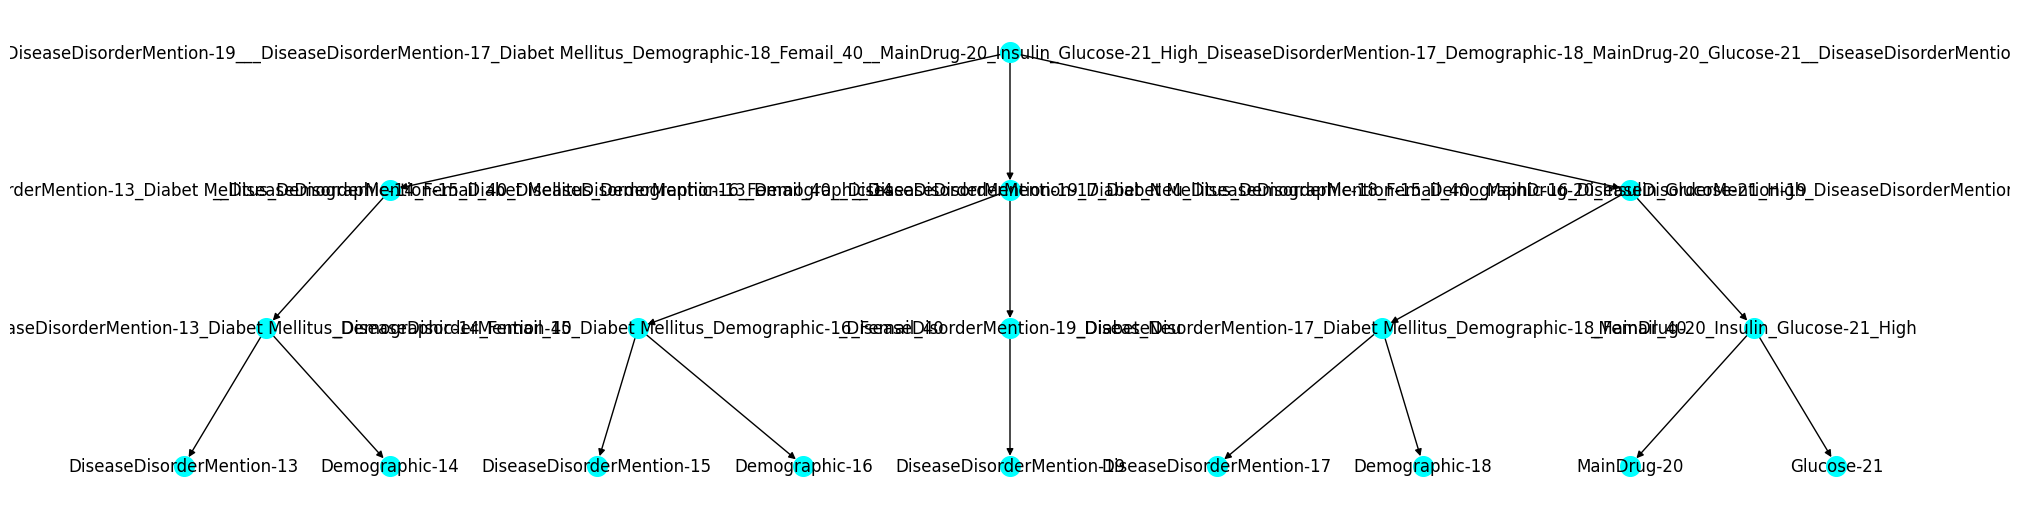

In [8]:
D=dict(nx.bfs_predecessors(PG, 'PID'))
Ls_tmp=[k for k,v in D.items() ]
for j in Ls_tmp:
    new_label_1=new_label_1+ '_'+j


mapping = {'PID':new_label_1}
PG = nx.relabel_nodes(PG, mapping)
root=new_label_1

pos = hierarchy_pos(PG,new_label_1)
plt.figure(1)
plt.figure(2,figsize=(20,5))
nx.draw(PG, pos=pos,with_labels=True,node_size = 200,node_color = 'cyan')
plt.show()

**Create final String**

In [9]:
import re

T = nx.bfs_tree(PG, source=root)
print(T)
bfs_string=list(T.nodes())
s1=bfs_string[0].replace('__','_')
s2=re.sub(r"(-[1-9][0-9]*)", r"", s1)
s2

DiGraph with 18 nodes and 17 edges


'_DiseaseDisorderMention_Diabet Mellitus_Demographic_Femail_40_MainDrug_Insulin_Glucose_High_DiseaseDisorderMention_Demographic_MainDrug_Glucose__DiseaseDisorderMention_Diabet Mellitus_Demographic_Femail_40_DiseaseDisorderMention_Demographic__DiseaseDisorderMention_Diabet Mellitus_Demographic_Femail_40_DiseaseDisorderMention_Diabet_Neu_DiseaseDisorderMention_Demographic_DiseaseDisorderMention__DiseaseDisorderMention_Diabet Mellitus_Demographic_Femail_40_MainDrug_Insulin_Glucose_High_DiseaseDisorderMention_Demographic_MainDrug_Glucose_DiseaseDisorderMention_Diabet Mellitus_Demographic_Femail_40_DiseaseDisorderMention_Diabet Mellitus_Demographic_Femail_40_DiseaseDisorderMention_Diabet_Neu_DiseaseDisorderMention_Diabet Mellitus_Demographic_Femail_40_MainDrug_Insulin_Glucose_High_DiseaseDisorderMention_Demographic_DiseaseDisorderMention_Demographic_DiseaseDisorderMention_DiseaseDisorderMention_Demographic_MainDrug_Glucose'

#Toy Example for Relabeling

---



<Figure size 640x480 with 0 Axes>

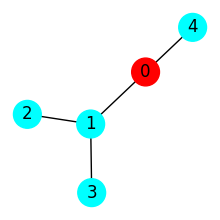

In [ ]:
G=nx.Graph()
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(0)
G.add_edge(1,2)
G.add_edge(1,3)
G.add_edge(0,1)
G.add_edge(0,4)
root=0
#--------------------------------------
pos = hierarchy_pos(G,0)      # positions for all nodes
plt.figure(1)
plt.figure(2,figsize=(2,2))
color_map = ['red' if node == root else 'cyan' for node in G]
nx.draw(G,with_labels=True,node_size = 400,node_color=color_map)
plt.show()
#--------------------------------------


{1: 0, 4: 0, 2: 1, 3: 1}


<Figure size 640x480 with 0 Axes>

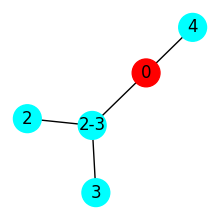

{'2-3': 0, 4: 0, 2: '2-3', 3: '2-3'}
2-3-4


<Figure size 640x480 with 0 Axes>

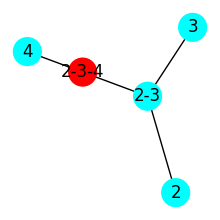

DiGraph with 5 nodes and 4 edges


['2-3-4', '2-3', 4, 2, 3]

In [ ]:
D=dict(nx.bfs_predecessors(G, 0))
print(D)

L_D_1=[str(k) for k,v in D.items() if str(v) == '1']
new_label_1='-'.join(L_D_1)

mapping = {1:new_label_1}
G = nx.relabel_nodes(G, mapping)

plt.figure(1)
plt.figure(2,figsize=(2,2))
color_map = ['red' if node == root else 'cyan' for node in G]
nx.draw(G,with_labels=True,node_size = 400,node_color=color_map)
plt.show()
#--------------------------------------
D=dict(nx.bfs_predecessors(G, 0))
print(D)

L_D_0=[str(k) for k,v in D.items() if str(v) == '0']
new_label_0='-'.join(L_D_0)
print(new_label_0)
mapping = {0:new_label_0}
root=new_label_0
G = nx.relabel_nodes(G, mapping)

plt.figure(1)
plt.figure(2,figsize=(2,2))
color_map = ['red' if node == root else 'cyan' for node in G]
nx.draw(G,with_labels=True,node_size = 400,node_color=color_map)
plt.show()

#--------------------------------------


T = nx.bfs_tree(G, source=root)
print(T)
bfs_string=list(T.nodes())
bfs_string